# Self Organizing Maps
unsupervised learning method  
https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf  
http://www.cs.bham.ac.uk/~jxb/NN/l16.pdf  
http://aa.ssdi.di.fct.unl.pt/files/AA-16_notes.pdf
- import libraries

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from minisom import MiniSom
import math
from pylab import bone, pcolor, colorbar, plot, show
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


- read the dataset

In [4]:
dataset = pd.read_csv('datasets/Credit_Card_Applications.csv')
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [134]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:, -1].values

- feature scaling

In [135]:
scaler   = MinMaxScaler() # default range is (0,1)
X_scaled = scaler.fit_transform(X)

- train the SOM

In [136]:
mapSize = math.ceil(math.sqrt(5*math.sqrt(len(X)))*4/5) # rule of thumb
mapSize

10

In [141]:
som = MiniSom(x=10,y=10, input_len=15, sigma=1.25, learning_rate=.25)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, 192) # data, iterations

- visualize the map (with pylab, not matplotlib)
- use mean inter-neuron distance (MID)
- add markers to identify fraud

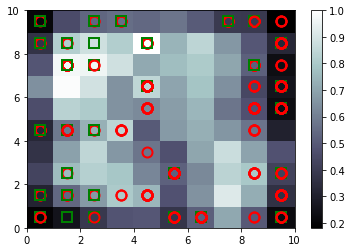

In [142]:
markers = ['o', 's'] # circle, square
colors  = ['r', 'g'] # red is no approval, green is approval
mid_map = som.distance_map()
bone() # creates an empty canvas
pcolor(mid_map.T)
colorbar() # higher number is correlated to outliers

for i,x in enumerate(X_scaled):
    node = som.winner(x)
    plot(node[0]+.5, node[1]+.5, markers[y[i]], markeredgecolor=colors[y[i]], markerfacecolor='None', markersize=10, markeredgewidth=2)  

- detect the potential frauds (light colors)

In [143]:
mappings = som.win_map(X_scaled)
frauds   = np.concatenate((mappings[(1,7)], mappings[(2,7)], mappings[(4,8)]), axis=0)
frauds   = scaler.inverse_transform(frauds)
print("list of potential fraudulent applicant IDs: ")
frauds[:,0]

list of potential fraudulent applicant IDs: 


array([15704581., 15725776., 15697460., 15737998., 15586183., 15718921.,
       15633944., 15607988., 15683993., 15797767., 15744044., 15632010.,
       15804235., 15627365., 15573798., 15700300., 15647295., 15791944.,
       15576680., 15620570., 15592412., 15608595., 15666166., 15665087.,
       15590434., 15567839., 15671014., 15579583., 15642336., 15740487.,
       15593345., 15811742., 15647191., 15702571., 15622083., 15646190.,
       15689692., 15672357., 15788634.])

- determine how many potential frauds were approved
- generate dependent variable for following step

In [144]:
final_list = []
y = np.zeros(len(dataset))
for i,x in enumerate(frauds[:,0]):
    for j in range(0, len(dataset)):
        if int(x) == int(dataset['CustomerID'].iloc[j]):
            final_list.append([x, dataset['Class'].iloc[j]])
            y[j] = 1;

final_list = np.array((final_list))
print("number of approved applications flagged as fraud: ", int(np.sum(final_list[:,1])))
print("total number of applications flagged as fraud: ", len(final_list))

number of approved applications flagged as fraud:  10
total number of applications flagged as fraud:  39


### Use an ANN to determine the probability of fraud

In [145]:
X      = dataset.iloc[:,1:].values
scaler = StandardScaler()
X      = scaler.fit_transform(X)

In [152]:
classifier = Sequential()
classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu', input_dim=15))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='relu'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier.fit(X, y, batch_size=1, epochs=4)

Epoch 1/4
690/690 [==============================] - 1s 2ms/step - loss: 0.3038 - acc: 0.9435
Epoch 2/4
690/690 [==============================] - 1s 1ms/step - loss: 0.1935 - acc: 0.9435
Epoch 3/4
690/690 [==============================] - 1s 1ms/step - loss: 0.1766 - acc: 0.9435
Epoch 4/4
690/690 [==============================] - 1s 1ms/step - loss: 0.1534 - acc: 0.9435


In [161]:
y_pred = classifier.predict(X)
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis=1)
y_pred = y_pred[y_pred[:,1].argsort()]

- find our flagged customers and plot with their probability of fraud

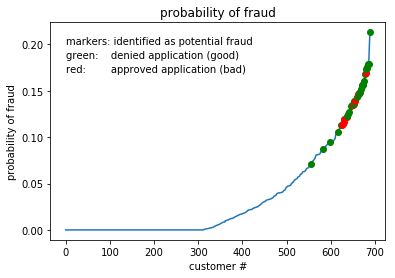

In [195]:
plt.plot(y_pred[:,1])
plt.title("probability of fraud")
plt.xlabel("customer #")
plt.ylabel("probability of fraud")
plt.annotate("markers: identified as potential fraud", xy=(.2,.2))
plt.annotate("green:    denied application (good)",xy=(0.185,0.185))
plt.annotate("red:        approved application (bad)", xy=(0.17,0.17))
for i,x in enumerate(y_pred):
    for j,y in enumerate(final_list):
        if x[0] == final_list[j,0]:
            if final_list[j,1] == 0.0:
                plot(i,y_pred[i,1], 'o', markerfacecolor='g', markeredgecolor='g')
            else:
                plot(i,y_pred[i,1], 'o', markerfacecolor='r', markeredgecolor='r')
plt.show()

In [176]:
for i,x in enumerate(y_pred):
    for j,y in enumerate(final_list):
        if x[0] ==final_list[j,0]:
            print(i,y_pred[i,1], final_list[j,1])

556 0.07097552716732025 0.0
583 0.08715880662202835 0.0
598 0.09474866092205048 0.0
617 0.10541120916604996 0.0
624 0.11344428360462189 0.0
625 0.1134578213095665 1.0
627 0.11464262008666992 1.0
629 0.116791732609272 1.0
631 0.11914525181055069 1.0
636 0.12182814627885818 1.0
637 0.1228957399725914 0.0
639 0.12466996908187866 0.0
641 0.12695437669754028 0.0
647 0.1331232488155365 0.0
649 0.1344071328639984 0.0
650 0.13476812839508057 1.0
652 0.13555409014225006 0.0
653 0.1384676694869995 0.0
655 0.1389642059803009 1.0
660 0.14330175518989563 0.0
661 0.1460697054862976 1.0
663 0.14619231224060059 0.0
664 0.14726322889328003 0.0
666 0.14805948734283447 1.0
667 0.14891627430915833 0.0
668 0.15140241384506226 0.0
670 0.15500199794769287 0.0
671 0.15642359852790833 0.0
672 0.15667200088500977 0.0
674 0.15759190917015076 0.0
676 0.16073784232139587 0.0
678 0.16824185848236084 0.0
679 0.16859182715415955 1.0
681 0.1736619472503662 0.0
682 0.17443996667861938 0.0
683 0.17516356706619263 0.0
68